In [1]:
# designed for assessing which games are the most popular, then exports the best to a json file
# so steam api data can be restricted

# we read in all the most popular steam games (as of 2018), then restrict to most popular - taking care to ensure that
# the game genres are fairly represented (we can't just pick the top 1,000, because that would exclude almost all indie games,
# or side scrollers - and if we exclude them then our model isn't applicable to people who only play those games)

In [2]:
import pandas as pd
import keyring
from queryer import QueryApi
from ast import literal_eval
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
password = keyring.get_password(service_name = 'steam', username = 'IcyJoseph')

In [4]:
api = QueryApi(password)

Successfully connected to the Steam API


In [5]:
df = pd.read_csv('datafiles/popular_games.csv', usecols = ['players_estimate', 'steam_app_id'], thousands = ",")
df['players_estimate'] = df['players_estimate'].replace(",","")
df = df.set_index('steam_app_id')

In [6]:
### get game genres

game_lookup = pd.DataFrame(columns = ['app_id','game_name','genre'])
maxruns = df.shape[0]

for runnum, game in enumerate(list(df.index)):
    
    try:
        gamereturn = api.get_game_info(game)
        
        genres = gamereturn['genre'].split(",")
        
        if len(genres) > 1: # most games have more than one genre, and it looks like they're in order of decreasing relevance
            genre = genres[0]+" "+genres[1] # take the top two - or just one if there aren't two
        else:
            genre = genres[0]
            
        genre = genre.replace("  "," ")
        
        temp_df = pd.DataFrame(index = [0], # we get the app_id, the name of the game and the genre
                data = {'app_id':game, 'game_name':gamereturn['name'], 'genre':genre})
        game_lookup = game_lookup.append(temp_df)
    
    except json.decoder.JSONDecodeError: # this error seems to be thrown when there's no API data on the app id
        continue

    print(f"run {runnum} of {maxruns} completed")
    
game_lookup = game_lookup.set_index('app_id')
game_lookup.to_csv('datafiles/game_genres.csv')

print("all runs have completed!")

run 0 of 13281 completed
run 1 of 13281 completed
run 2 of 13281 completed
run 3 of 13281 completed
run 4 of 13281 completed
run 5 of 13281 completed
run 6 of 13281 completed
run 7 of 13281 completed
run 8 of 13281 completed
run 9 of 13281 completed
run 10 of 13281 completed
run 11 of 13281 completed
run 12 of 13281 completed
run 13 of 13281 completed
run 14 of 13281 completed
run 15 of 13281 completed
run 16 of 13281 completed
run 17 of 13281 completed
run 18 of 13281 completed
run 19 of 13281 completed
run 20 of 13281 completed
run 21 of 13281 completed
run 22 of 13281 completed
run 23 of 13281 completed
run 24 of 13281 completed
run 25 of 13281 completed
run 26 of 13281 completed
run 27 of 13281 completed
run 28 of 13281 completed
run 29 of 13281 completed
run 30 of 13281 completed
run 31 of 13281 completed
run 32 of 13281 completed
run 33 of 13281 completed
run 34 of 13281 completed
run 35 of 13281 completed
run 36 of 13281 completed
run 37 of 13281 completed
run 38 of 13281 comple

KeyboardInterrupt: 

### get proportional size of each game genre

In [7]:
game_lookup = pd.read_csv('datafiles/game_genres.csv', index_col = 'app_id')

In [8]:
game_lookup.head()

,game_name,genre
app_id,,
440,Team Fortress 2,Action Free to Play
730,Counter-Strike: Global Offensive,Action Free to Play
578080,PLAYERUNKNOWN'S BATTLEGROUNDS,Action Adventure
304930,Unturned,Action Adventure
550,Left 4 Dead 2,Action


In [31]:
genres = pd.DataFrame(
    game_lookup.groupby('genre')['game_name'].count()/game_lookup.shape[0]) # what % of all games does this genre cover?
genres.columns = ['proportion']

In [10]:
genres.head()

,proportion
genre,
Action,0.031223
Action Adventure,0.173938
Action Casual,0.086684
Action Early Access,0.000855
Action Free to Play,0.011406


In [32]:
fewgames = pd.DataFrame(game_lookup.groupby('genre')['game_name'].count()) # we'll drop genres with only 1 or 2 games
fewgames.columns = ['num_games']
fewgames = fewgames.sort_values('num_games', ascending = True)
fewgames = fewgames[fewgames['num_games'] <= 2]

# these are the genres that will feature in our final list of games
useful_genres = game_lookup[game_lookup['genre'].isin(fewgames.index) == False] 
useful_genres = pd.DataFrame(useful_genres.groupby('genre')['game_name'].count()/useful_genres.shape[0])
useful_genres.columns = ['proportion']

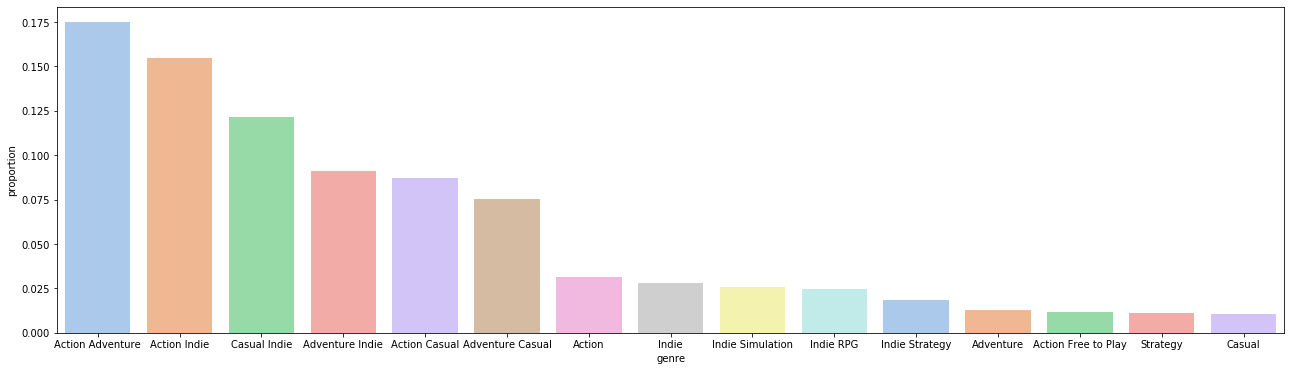

In [33]:
high_freq_genres = useful_genres[useful_genres['proportion'] >= 0.01].copy()
high_freq_genres = high_freq_genres.sort_values('proportion', ascending = False)

plt.figure('most popular genres', (22,6))
sns.barplot(x = high_freq_genres.index, y = high_freq_genres['proportion'], palette = 'pastel');
# action/adventure/indie are by far the most popular games

### selecting the actual games for the final game dataset

In [34]:
# if we have 1,000 games, this is how many of each genre are allowed - for a fair representation
useful_genres['num_games_allowed'] = round(1000*useful_genres['proportion'])

In [35]:
# combine game name, number of players, and genre
game_fct = df.merge(game_lookup, how = 'inner', left_index = True, right_index = True)
game_fct = game_fct[game_fct['genre'].isin(fewgames.index) == False]

In [36]:
# the most popular game IN EACH GENRE gets rank 1, then 2 etc. 
game_fct['rank'] = game_fct.groupby('genre')['players_estimate'].rank(method = 'first', ascending = False)

In [37]:
game_fct.sort_values('players_estimate', ascending = False).head(10)

,players_estimate,game_name,genre,rank
440,50191347,Team Fortress 2,Action Free to Play,1.0
730,46305966,Counter-Strike: Global Offensive,Action Free to Play,2.0
578080,36604134,PLAYERUNKNOWN'S BATTLEGROUNDS,Action Adventure,1.0
304930,27381399,Unturned,Action Adventure,2.0
550,23143723,Left 4 Dead 2,Action,1.0
218620,18643807,PAYDAY 2,Action RPG,1.0
4000,18576379,Garry's Mod,Indie Simulation,1.0
230410,16332217,Warframe,Action Free to Play,3.0
240,15001876,Counter-Strike: Source,Action,2.0
444090,14371946,Paladins,Action Free to Play,4.0


In [38]:
game_fct = game_fct.reset_index()
game_fct.columns = ['app_id', 'players_estimate', 'game_name', 'genre', 'rank']
games_to_keep = game_fct.merge(useful_genres, how = 'inner', left_on = 'genre', right_on = 'genre')

# game's rank must be equal to or below the maximum number of games allowed for that genre
games_to_keep = pd.DataFrame(games_to_keep[games_to_keep['rank'] <= games_to_keep['num_games_allowed']]['app_id'])

In [40]:
games_to_keep.to_csv('datafiles/gamesfilter.csv', index = False)